# DAML 08 - Principal Component Analysis

Michal Grochmal <michal.grochmal@city.ac.uk>

PCA is an unsupervised algorithm which reduces the feature space.
The algorithm builds a projection of the feature space into a space
with a smaller number of dimensions.
The new feature space is not necessarily meaningful in terms of the original features,
because the projection plane (or hyperplane) may cross the features diagonally.

The algorithm works by decomposing the space into eigenvectors and eigenvalues.
Then it reorders the eigenvectors in order of how much variance they explain.
Each eigenvector is parallel to each other,
therefore reordering them does not impact the data representation.
The maximum number of eigenvectors for data in $N$ dimensions is $N$
but the power of PCA is that we can use less than $N$ eigenvectors
to get a *"good enough"* representation of the data.
Moreover, we know that these will be the first eigenvectors once the
algorithm has ordered all eigenvectors in variance order.

Let's build a small example.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-talk')
from mpl_toolkits import mplot3d

We will plot two classes: red and blue, in three dimensions.
The *meshgrid* produces all combinations between $x$ and $y$ features,
and we build a almost-dependent $z$ feature.
Since the $z$ feature is almost fully dependent on the values of $x$ and $y$,
the variance in $z$ can be explained by the variance in $x$ and $y$.
We expect that PCA will figure that out and flatten out the $z$ feature.

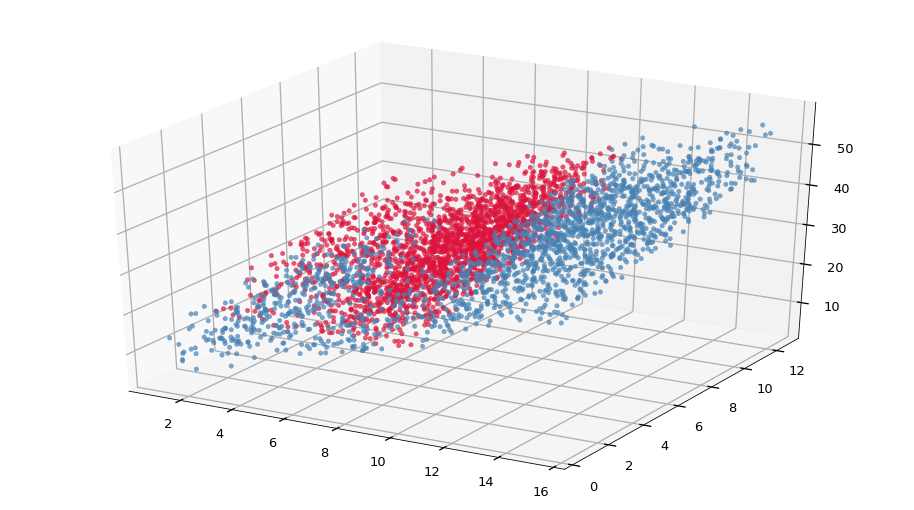

In [2]:
points = 64
x = np.linspace(0, 10, points) + 7*np.random.rand(points)
y = np.linspace(0, 10, points) + 3*np.random.rand(points)
gx, gy = np.meshgrid(x, y)
z = 2*gx + gy + 15*np.random.rand(points, points)
red = (z > 20) & (x < 10)
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[red], gy[red], z[red], c='crimson', alpha=0.7)
ax.scatter(gx[~red], gy[~red], z[~red], c='steelblue', alpha=0.7);

PCA expects to be given the number of components we project onto,
this is a hyperparameter of the PCA algorithm.
We are rather confident that we can take the data above and
live with its variance in two dimensions only,
therefore we will use 2 components.

We use `fit_transform` on our model.
This is equivalent to calling `fit` and `transform` on the same data.
Where the `transform` is a typical method of unsupervised learning/preprocessing models,
akin of the `predict` method of classification and regression models.

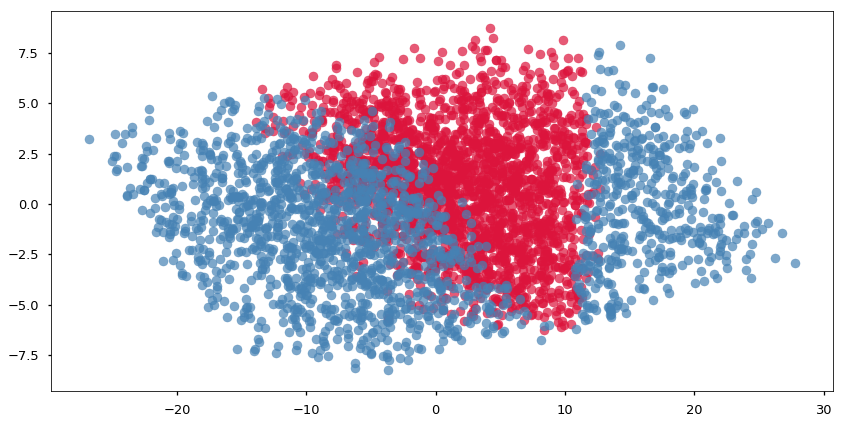

In [3]:
from sklearn.decomposition import PCA
X = np.c_[gx.reshape(-1), gy.reshape(-1), z.reshape(-1)]
pca = PCA(n_components=2)
X_new = pca.fit_transform(X)
red_new = red.reshape(-1)
fig, ax = plt.subplots(figsize=(14, 7))
ax.scatter(X_new[red_new, 0], X_new[red_new, 1], color='crimson', alpha=0.7)
ax.scatter(X_new[~red_new, 0], X_new[~red_new, 1], color='steelblue', alpha=0.7);

That look good but how PCA makes this projection?
The main part of the PCA algorithm is singular value decomposition.
Assuming that our data is centered at zero
(something easy to perform, just subtract the mean in every dimension)
we can decompose the samples matrix $M$ as:

$$M = U \Sigma V^* $$

Both $U$ and $V$ are unitary matrices, and $\Sigma$ is a diagonal matrix.
Since we have only real numbers in the matrices we can shift values around and end with:

$$M = Q \Sigma Q^* $$

i.e. we made $U$ and $V$ to be unitary to each other.
Now $Q$ contains the eigenvectors - components - of the original matrix
and $\Sigma$ contains the eigenvalues - explained variance.
We can swap numbers in the diagonal of $\Sigma$
as long as we swap the same rows in $Q$,
therefore we can order the vectors by the magnitude of the value
in the diagonal of $\Sigma$.

PCA keeps track of the eigenvectors/components and eigenvalues/variance.
This allows us to plot how the projection has been performed.

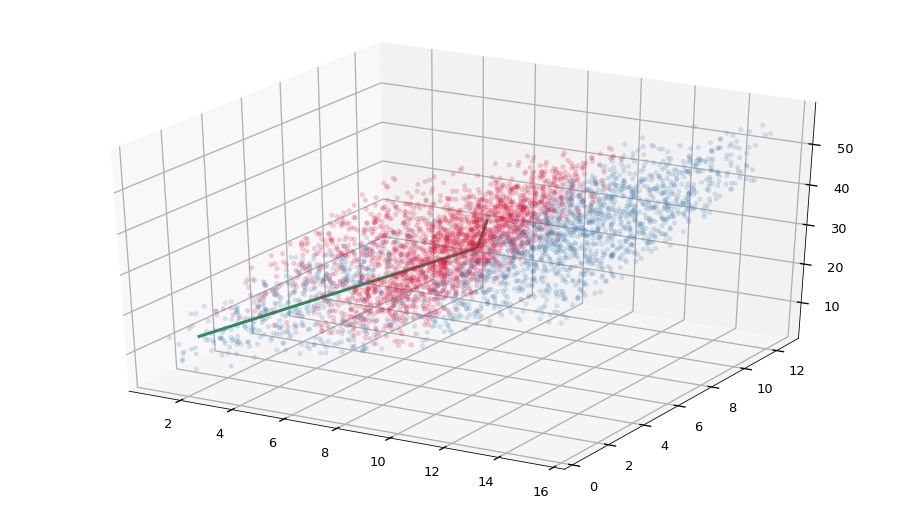

In [4]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gx[red], gy[red], z[red], c='crimson', alpha=0.2)
ax.scatter(gx[~red], gy[~red], z[~red], c='steelblue', alpha=0.2);

M = np.c_[gx.mean(), gy.mean(), z.mean()]
sizes = pca.explained_variance_ratio_ / pca.explained_variance_ratio_.min()
eigen = pca.components_ * sizes[:, np.newaxis]
ax.quiver(M[[0, 0], 0], M[[0, 0], 1], M[[0, 0], 2],
          eigen[:, 0], eigen[:, 1], eigen[:, 2],
          linewidths=3, color='seagreen', length=3, arrow_length_ratio=0);

## Eigenfaces

When used on faces,
and since eigenvectors have been used on faces over the years in many applications,
the eigenvectors are often called *eigenfaces*.
The eigenfaces represent the biggest directions of variations across a dataset of faces,
and are one of the most common techniques in face recognition.

To get some faces we will use the *Labeled Faces in the Wild* dataset,
which contains thousands of cropped photos to show only the face.
This dataset has been produced in early 2000s, therefore has mostly people often photographed at that time.

In [5]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
print(faces.target_names)
faces.images.shape, faces.data.shape

['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger' 'Colin Powell' 'David Beckham' 'Donald Rumsfeld'
 'George W Bush' 'Gerhard Schroeder' 'Gloria Macapagal Arroyo'
 'Guillermo Coria' 'Hans Blix' 'Hugo Chavez' 'Jacques Chirac'
 'Jean Chretien' 'Jennifer Capriati' 'John Ashcroft' 'John Negroponte'
 'Junichiro Koizumi' 'Kofi Annan' 'Laura Bush' 'Lleyton Hewitt'
 'Luiz Inacio Lula da Silva' 'Megawati Sukarnoputri' 'Nestor Kirchner'
 'Recep Tayyip Erdogan' 'Roh Moo-hyun' 'Serena Williams'
 'Silvio Berlusconi' 'Tom Ridge' 'Tony Blair' 'Vicente Fox'
 'Vladimir Putin']


((2370, 62, 47), (2370, 2914))

Every image is 62 times 47 pixels, or 2914 pixels in total.
We argue that we have 2914 different features.
`matplotlib` provides us with `imshow`.
Since we are working with images, this is perfect to see what we are working with.
Note that the orientation of the faces changes between the samples.

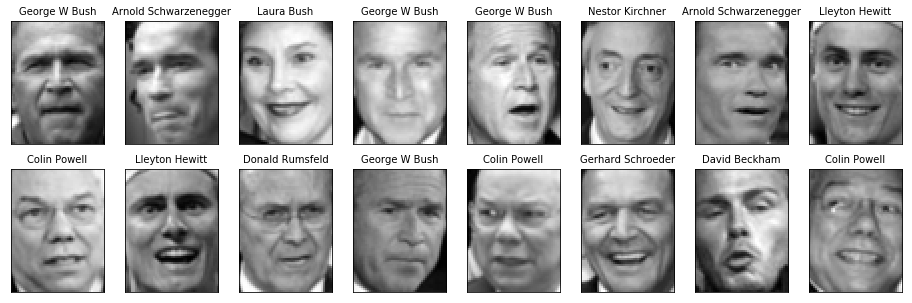

In [6]:
fig, axes = plt.subplots(2, 8, figsize=(16, 5), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, ax in enumerate(axes.flat):
    ax.imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax.set_title(faces.target_names[faces.target[i]], fontsize=10)

A rule of thumb is that, for images, $2 \sqrt N$ is a good number of reduced features.
We will use 128, since it is close to the square root of 2914 and a power of 2.
PCA `components_` are the eigenvector orientation, i.e. the direction of the vector
in the dimensions of the original dataset.  The `explained_variance_` are the vector
magnitudes.

We will use a *randomized* solver for this dataset.
The randomized solver uses a heuristic method to identify the first couple of eigenvectors.
Solving the decomposition problem analytically is actually very costly for big datasets,
the randomized solver alleviates this considerably.

In [7]:
pca = PCA(n_components=128, svd_solver='randomized')
pca.fit(faces.data)
pca.components_, pca.components_.shape, pca.explained_variance_

(array([[-0.0057819 , -0.00647535, -0.00750266, ..., -0.00750292,
         -0.006322  , -0.00540362],
        [ 0.01553343,  0.01490464,  0.01502994, ..., -0.03539123,
         -0.03405764, -0.03245888],
        [ 0.04338677,  0.04443824,  0.04592456, ...,  0.02255627,
          0.02074249,  0.0183293 ],
        ..., 
        [-0.04596872, -0.04043406, -0.01309459, ..., -0.0337235 ,
          0.01007985,  0.02717283],
        [ 0.0116968 ,  0.01391272,  0.01751823, ..., -0.05044067,
         -0.01830726,  0.01552305],
        [ 0.03597187,  0.02575867, -0.00382315, ...,  0.02499309,
          0.01188911, -0.0067142 ]], dtype=float32),
 (128, 2914),
 array([ 982217.1875    ,  581732.1875    ,  328733.875     ,
         298409.625     ,  197671.71875   ,  137052.625     ,
          97544.015625  ,   86715.8359375 ,   83363.        ,
          74749.265625  ,   72634.734375  ,   64542.88671875,
          58063.77734375,   50905.5703125 ,   49381.109375  ,
          44700.375     ,   43049

Perhaps we can see how the eigenvectors actually look.
We can display images of 2914 features/pixels,
the eigenvectors have exactly the same number of dimensions so we can plot them the same way.
These are the actual *eigenfaces*.

We plot the eigenfaces in order of explained variance,
from the eigenface that explains the most in descending order.

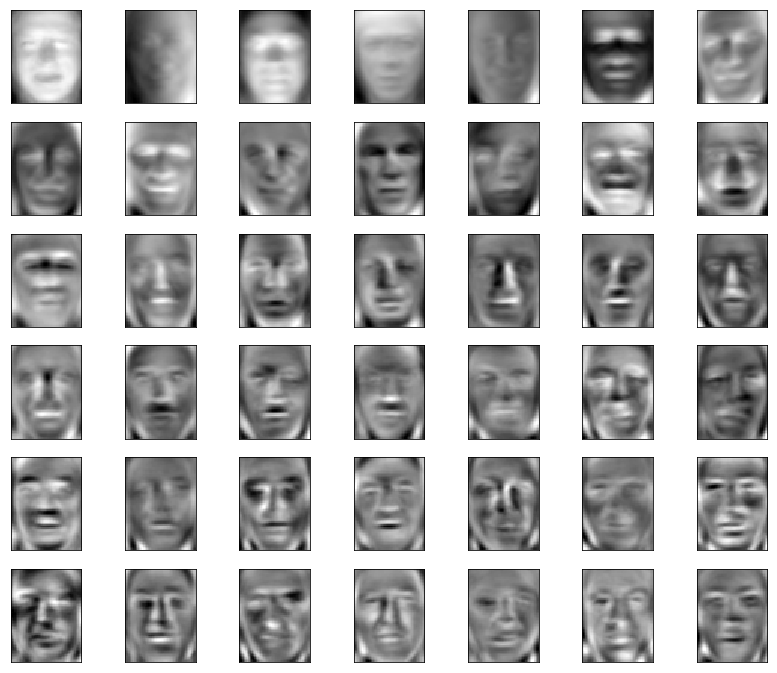

In [8]:
fig, axes = plt.subplots(6, 7, figsize=(14, 12), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='binary')

The most important eigenfaces/eigenvectors are changes
in illumination and orientation of the face.
At first sight we may argue that that would be a problem if we would try to build a classifier.
By the contrary, the PCA managed to move (most of) the illumination and orientation
into their own dimensions, which means they were removed from the other dimensions.
We could tweak the PCA output to prevent the first eigenvectors from being used.
Yet, that's a topic for another time.

We saw that we order the eigenvectors in explained variance order.
But how much variance each eigenvector explains?
We often want to plot a cumulative explained variance,
to understand how many components we actually need.
Let's rebuild the PCA with 512 components
(we have no need to build all 2914 eigenvectors)
and evaluate whether our choice of 128 components was good.

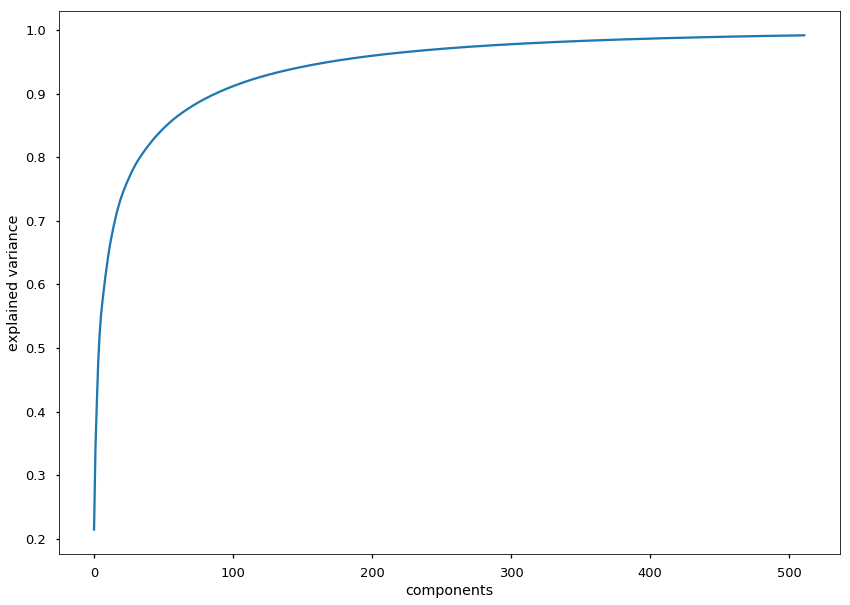

In [9]:
pca = PCA(n_components=512, svd_solver='randomized')
pca.fit(faces.data)
fig, ax = plt.subplots(figsize=(14, 10))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set(xlabel='components', ylabel='explained variance');

The `transform` of the PCA technique projects the data into the space defined by the eigenvectors.
This operation **loses some information** but since the majority
of the variance is retained the loss is as minimal as possible.
The `inverse_transform` can throw the projection back into the original dimensions,
yet the data loss remains since we cannot guess that data.

This allows us to visualize how much data was actually lost.

In [10]:
proj = {}
for i in [128, 256]:
    pca = PCA(n_components=i, svd_solver='randomized')
    pca.fit(faces.data)
    reduced = pca.transform(faces.data)
    proj[i] = pca.inverse_transform(reduced)

We have projected the images into 128 and 256 dimensions.
And if we plot them next to each other we can visually inspect the data loss.

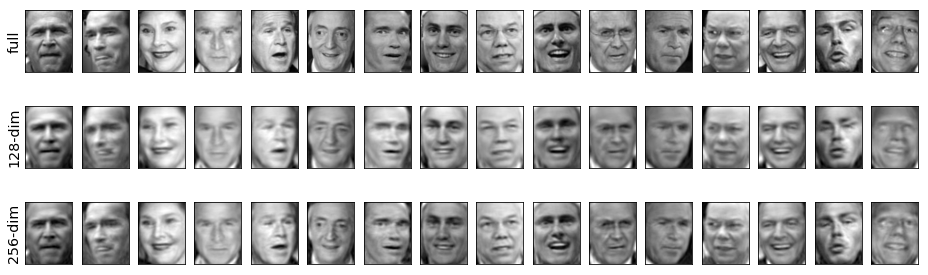

In [11]:
fig, ax = plt.subplots(3, 16, figsize=(16, 5), subplot_kw={'xticks':[], 'yticks':[]})
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(16):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(proj[128][i].reshape(62, 47), cmap='binary_r')
    ax[2, i].imshow(proj[256][i].reshape(62, 47), cmap='binary_r')
ax[0, 0].set_ylabel('full')
ax[1, 0].set_ylabel('128-dim');
ax[2, 0].set_ylabel('256-dim');

## Digits

Another dataset of images are the MNIST handwritten digits.
This dataset is often used for algorithm benchmark due to its complexity.

In [12]:
from sklearn.datasets import load_digits
digits = load_digits()
print(digits['DESCR'])
digits.data.shape, digits.images.shape

Optical Recognition of Handwritten Digits Data Set

Notes
-----
Data Set Characteristics:
    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each block. This generates
an input matrix of 8x8 where each element is a

((1797, 64), (1797, 8, 8))

The number of dimensions (64) in this dataset is much smaller
than in the faces dataset.
Moreover, we know very well the labels: digits from 0 to 9.
We may as well try to visualize the distribution of each digit.
In other words, we'll try to reduce the digits to a representation in two dimensions.

These are 8 pixels by 8 pixels images.
As we did with the faces we can plot them to see what we are working with.

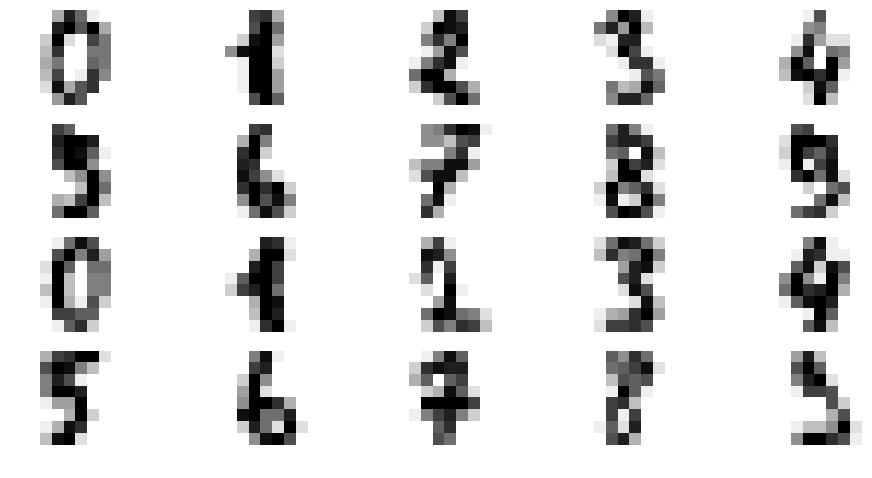

In [13]:
sample = digits.images[:20, :]
fig, ax = plt.subplots(4, 5, figsize=(16, 8))
for i in range(20):
    ax.flat[i].imshow(sample[i], cmap='binary')
    ax.flat[i].axis('off')

We can use the analytic solver for a small number of dimensions.

In [14]:
pca = PCA(n_components=2)
proj = pca.fit_transform(digits.data)
digits.data.shape, proj.shape

((1797, 64), (1797, 2))

We have the digits as a representation in two dimensions.
On important thing of `fit_transform` (and `transform` too)
is that it keeps the order of the samples it is fed.
This is true for almost all operation in `sklearn`.

Since we have the same order of the samples in two dimensions,
and the dataset provides us with the correct labels for the digits,
we can plot each digit with a specific color.
We build the colors from a color map and even add a label
in the median of the digit.

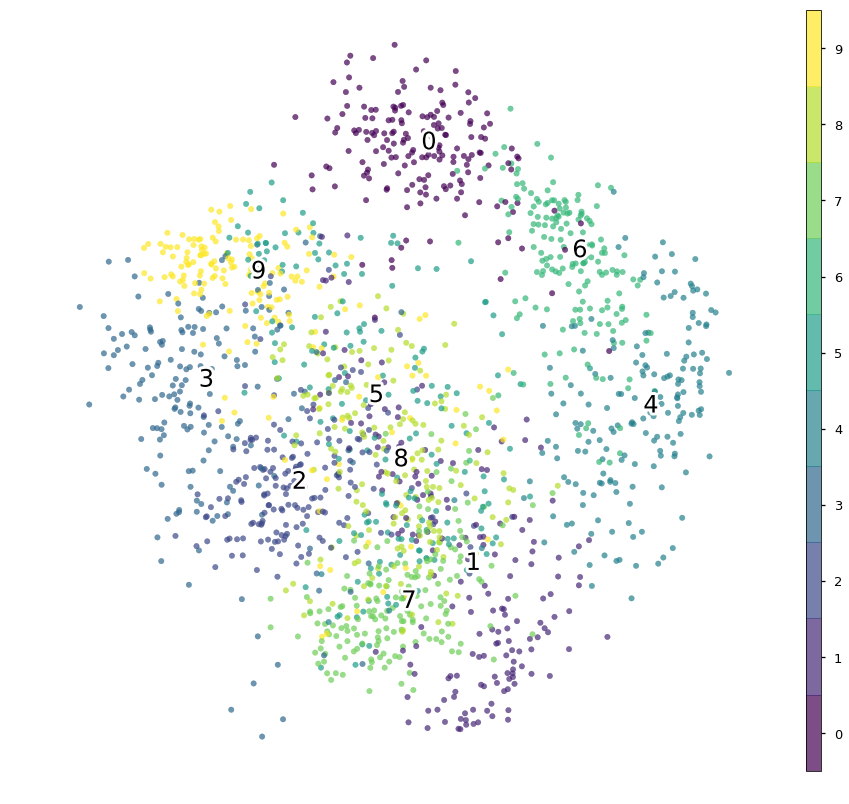

In [15]:
import matplotlib.patheffects as mplpf
fig, ax = plt.subplots(figsize=(16, 14))
plot = ax.scatter(proj[:, 0], proj[:, 1], s=30, c=digits.target,
                  alpha=0.7, cmap=plt.cm.get_cmap('viridis', 10))
plot.set_clim(-0.5, 9.5)  # make the ticks look right
ax.axis('off')
ticks = np.array(range(10))
fig.colorbar(plot, ax=ax, aspect=50, ticks=ticks)
for i in range(10):
    xtext, ytext = np.median(proj[digits.target == i, :], axis=0)
    txt = ax.text(xtext, ytext, str(i), fontsize=24)
    txt.set_path_effects([
        mplpf.Stroke(linewidth=6, foreground='white'), mplpf.Normal()])

That may look colorful but isn't very promising.
We can see the 5 and 8 or 1 and 7 are very related to each other,
which is what we expect since we know how digits look.
Yet, the separation between classes is very poor.

Let's build the full PCA (on all dimensions) and see the cumulative explained variance.
This should give us an idea of where we went wrong.

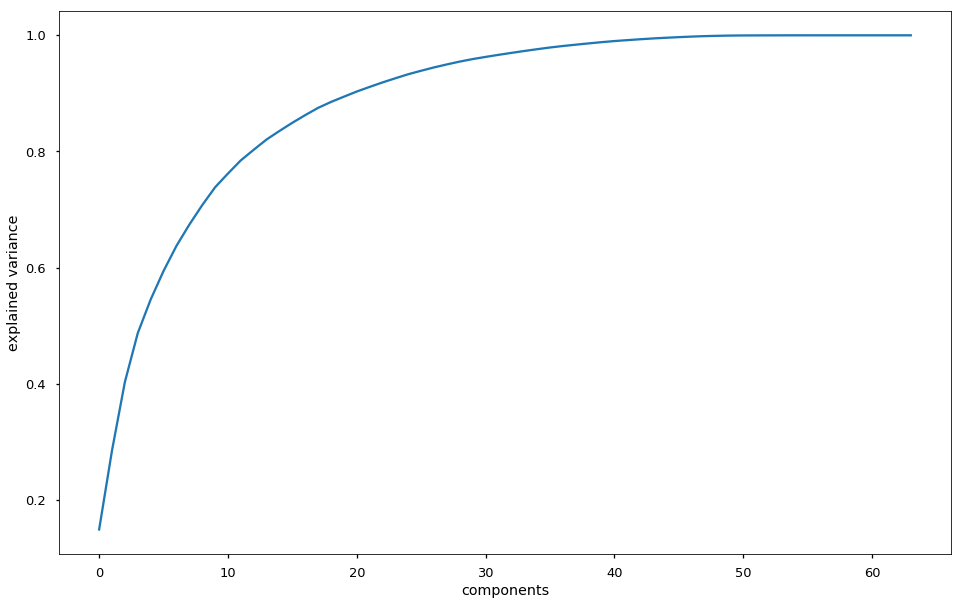

In [16]:
pca = PCA().fit(digits.data)
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot(np.cumsum(pca.explained_variance_ratio_))
ax.set(xlabel='components', ylabel='explained variance');

Only 2 components do a very bad job of explaining the dataset,
even 10 components would do a bad job.
PCA will not allow us to visualize this dataset.

### Linearity of PCA and manifold techniques

The issue with the digits happens because PCA is a technique
that depends on the linearity of the dimensions it works with.
Relations that are non-linear,
e.g. two open spaces means an 8, one open space means a 6 or a 9,
no open spaces within the digit means anything else;
cannot be captured by PCA.

To deal with non-linear relationships manifold techniques were developed.
These techniques are based on maintaining distances between points in the data
instead of maintaining the variance within specific dimensions.
That said, PCA is easy to interpret due to the cumulative variance,
yet it is often difficult to interpret what a manifold technique is doing.
Moreover, there is no definitive measure of whether a manifold technique will
or will not converge for a particular dataset,
and manifold techniques are more sensitive to outliers than PCA.

As a rule of thumb,
it is wise to attempt manifold techniques only after attempting PCA
and understanding the shape of the data.
Some manifold techniques include:

-   Multidimensional Scaling (MDS) is the simplest manifold which works by preserving
    (as much as possible) the distances between *all* points in the dataset.

-   Locally Linear Embedding (LLE) works like MDS but only preserves distances within
    a defined number of neighbors, this allows to "unroll" certain relationships.

-   Isomap is similar to LLE in that it uses a neighbor search but then computes
    eigenvectors over the local groups.

-   Spectral Embedding is a stochastic way of building eigenmaps from a graph based
    neighbor search, this makes it similar to LLE.

-   t-distributed Stochastic Neighbor Embedding (t-SNE) may reveal structures at
    different scales since it builds several t-distributions (similar to a bell shape)
    within groups of neighbors and then works with these t-distributions instead
    of the actual data points.